# A/B Testing Masterclass: Advanced Techniques at Scale
## Criteo Uplift Modeling Analysis

---

### Learning Objectives

By the end of this notebook, you will understand:

1. **Large-Scale Data Handling** - Efficient sampling strategies for millions of rows
2. **SRM with Designed Imbalance** - Handling intentionally unequal allocation (15/85)
3. **CUPAC** - ML-enhanced variance reduction (beyond linear CUPED)
4. **Heterogeneous Treatment Effects** - X-Learner for personalization
5. **Sequential Testing** - O'Brien-Fleming boundaries for early stopping
6. **Guardrails at Scale** - Protecting critical metrics in large experiments

---

### The Business Context

**Criteo** is a major ad tech company that serves billions of ads daily. This dataset (13.9M observations) comes from their uplift modeling research - predicting WHO will respond positively to ads.

**Why Large-Scale Matters:**
- Detect small but valuable effects (1% lift at billion-dollar scale = millions)
- Enable advanced ML techniques (CUPAC needs rich feature data)
- Support personalization (X-Learner needs large samples per segment)
- But: Small effects can be statistically significant but practically meaningless

**The Metrics:**
- **Visit Rate**: Did the user visit the website after seeing the ad?
- **Conversion Rate**: Did the user make a purchase?

---

## Setup and Data Loading

In [1]:
import os

if not os.getcwd().endswith("ab_testing"):
    try:
        os.chdir("../")
    except OSError:
        raise FileNotFoundError("Could not change into 'ab_testing' from the current directory.")

print(f"Current working directory: {os.getcwd()}")


Current working directory: c:\docker_projects\ab_testing


In [2]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

# A/B Testing modules
from ab_testing.data import loaders
from ab_testing.core import randomization, frequentist
from ab_testing.variance_reduction import cupac
from ab_testing.advanced import hte, sequential
from ab_testing.diagnostics import guardrails

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("✓ Modules loaded successfully")

✓ Modules loaded successfully


### Understanding Sampling Strategy

The full Criteo dataset has **13.9 million observations**. For learning purposes, we'll use a sample:

| Sample Fraction | Rows | Use Case |
|-----------------|------|----------|
| 0.001 (0.1%) | ~14K | Quick testing, learning |
| 0.01 (1%) | ~139K | Development, validation |
| 0.1 (10%) | ~1.4M | Production-quality analysis |
| 1.0 (100%) | ~13.9M | Final analysis (memory intensive) |

**Trade-off:** More data = more precision but slower computation

In [3]:
# Load with 0.1% sample for learning (fast but still demonstrates concepts)
SAMPLE_FRAC = 0.001  # Adjust based on your compute resources

print(f"Loading Criteo dataset with {SAMPLE_FRAC*100:.1f}% sample...")
print(f"Expected rows: ~{int(13.9e6 * SAMPLE_FRAC):,}")

df = loaders.load_criteo_uplift(sample_frac=SAMPLE_FRAC)

print(f"\n✓ Loaded {len(df):,} observations")
print(f"\nColumns: {list(df.columns)}")

Loading Criteo dataset with 0.1% sample...
Expected rows: ~13,900

✓ Loaded 13,980 observations

Columns: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'visit', 'treatment', 'conversion']


In [4]:
# Understand the data structure
print("Dataset Summary:")
print("=" * 50)

# Identify feature columns
feature_cols = [col for col in df.columns if col not in ['treatment', 'visit', 'conversion']]
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols[:5]}...")

print(f"\nGroup distribution:")
print(df['treatment'].value_counts())

print(f"\nAllocation:")
n_control = (df['treatment'] == 0).sum()
n_treatment = (df['treatment'] == 1).sum()
total = len(df)
print(f"  Control: {n_control:,} ({n_control/total:.1%})")
print(f"  Treatment: {n_treatment:,} ({n_treatment/total:.1%})")

print(f"\nOutcome rates:")
print(f"  Visit rate (control):    {df[df['treatment']==0]['visit'].mean():.4f}")
print(f"  Visit rate (treatment):  {df[df['treatment']==1]['visit'].mean():.4f}")
print(f"  Conversion rate (control):    {df[df['treatment']==0]['conversion'].mean():.4f}")
print(f"  Conversion rate (treatment):  {df[df['treatment']==1]['conversion'].mean():.4f}")

Dataset Summary:

Feature columns (12): ['f0', 'f1', 'f2', 'f3', 'f4']...

Group distribution:
treatment
1    11949
0     2031
Name: count, dtype: Int64

Allocation:
  Control: 2,031 (14.5%)
  Treatment: 11,949 (85.5%)

Outcome rates:
  Visit rate (control):    0.0325
  Visit rate (treatment):  0.0503
  Conversion rate (control):    0.0010
  Conversion rate (treatment):  0.0028


---

## Step 1: SRM Check with Designed Imbalance

### Key Insight: Not All Imbalance is Bad

The Criteo dataset has ~15/85 allocation (control/treatment). This is **BY DESIGN**, not an error!

**Why companies use imbalanced allocation:**

| Reason | Example |
|--------|--------|
| **Cost** | Treatment costs money (ad spend) |
| **Risk** | Minimize exposure to potentially harmful treatment |
| **Ramp-up** | Start small, increase if safe |
| **Power optimization** | When treatment variance differs from control |

### SRM Check for Imbalanced Designs

Instead of expecting 50/50, we check against the **designed allocation** (15/85).

---

In [5]:
# Separate groups
control = df[df['treatment'] == 0]
treatment = df[df['treatment'] == 1]

# Dataset has designed 15/85 imbalanced allocation
IS_RCT = True  # This IS a randomized trial (just imbalanced)
EXPECTED_ALLOCATION = [0.15, 0.85]  # Designed split

print("Dataset Configuration:")
print("=" * 50)
print(f"Type: Randomized Controlled Trial (imbalanced)")
print(f"Expected allocation: {EXPECTED_ALLOCATION[0]:.0%} / {EXPECTED_ALLOCATION[1]:.0%}")
print(f"Observed allocation: {n_control/total:.1%} / {n_treatment/total:.1%}")

Dataset Configuration:
Type: Randomized Controlled Trial (imbalanced)
Expected allocation: 15% / 85%
Observed allocation: 14.5% / 85.5%


In [6]:
# Two-stage SRM check with designed allocation
srm_result = randomization.srm_check(
    n_control=n_control,
    n_treatment=n_treatment,
    expected_ratio=EXPECTED_ALLOCATION,  # Check against DESIGNED ratio
    alpha=0.01,
    pp_threshold=0.01,  # 1 percentage point deviation
    count_threshold=None
)

print("\nSRM Check Results (Two-Stage):")
print("=" * 50)
print(f"\nStage A - Statistical Significance:")
print(f"  Chi-square: {srm_result['chi2_statistic']:.4f}")
print(f"  P-value:    {srm_result['p_value']:.6f}")
print(f"  Statistical SRM (p < 0.01): {srm_result['srm_detected']}")

print(f"\nStage B - Practical Significance:")
print(f"  Max pp deviation: {srm_result['max_pp_deviation']:.4f}")
print(f"  Practical SRM (> 1pp): {srm_result['practical_significant']}")

print(f"\nCombined Assessment:")
if srm_result['srm_severe']:
    print(f"  ❌ SEVERE: Both statistical AND practical significance")
    print(f"     STOP - investigate randomization")
elif srm_result['srm_warning']:
    print(f"  ⚠️  WARNING: Statistical but NOT practical significance")
    print(f"     Large sample makes tiny deviations detectable")
    print(f"     Proceeding with caution")
else:
    print(f"  ✓ PASSED: No statistical or practical concerns")
    print(f"     Allocation matches designed ratio")


SRM Check Results (Two-Stage):

Stage A - Statistical Significance:
  Chi-square: 2.4438
  P-value:    0.117988
  Statistical SRM (p < 0.01): False

Stage B - Practical Significance:
  Max pp deviation: 0.0047
  Practical SRM (> 1pp): False

Combined Assessment:
  ✓ PASSED: No statistical or practical concerns
     Allocation matches designed ratio


In [7]:
# Hard gate - only proceed if SRM is not severe
if IS_RCT and srm_result['srm_severe']:
    print("\n" + "=" * 60)
    print("⛔ ANALYSIS HALTED: Severe SRM Failure in RCT")
    print("=" * 60)
    print("\nNo statistical inference will be performed.")
    print("Investigate randomization before proceeding.")
    # In production: return early
else:
    print("\n✓ SRM check passed - proceeding with analysis")


✓ SRM check passed - proceeding with analysis


---

## Step 2: Primary Metric Analysis (Visit Rate)

With large samples, even tiny effects become statistically significant. The key question is: **Is it practically meaningful?**

---

In [8]:
# Z-test for visit rate
x_control_visits = control['visit'].sum()
x_treatment_visits = treatment['visit'].sum()

primary_result = frequentist.z_test_proportions(
    x_control=x_control_visits,
    n_control=len(control),
    x_treatment=x_treatment_visits,
    n_treatment=len(treatment),
    alpha=0.05,
    two_sided=True
)

print("Primary Metric: Visit Rate")
print("=" * 50)
print(f"\nControl:   {control['visit'].mean():.6f} ({x_control_visits:,}/{len(control):,})")
print(f"Treatment: {treatment['visit'].mean():.6f} ({x_treatment_visits:,}/{len(treatment):,})")
print(f"\nAbsolute difference: {primary_result['absolute_lift']:.6f}")
print(f"Relative lift:       {primary_result['relative_lift']:.2%}")
print(f"\nZ-statistic: {primary_result['z_statistic']:.4f}")
print(f"P-value:     {primary_result['p_value']:.6f}")
print(f"95% CI:      [{primary_result['ci_lower']:.6f}, {primary_result['ci_upper']:.6f}]")
print(f"\nStatistically significant: {primary_result['significant']}")

Primary Metric: Visit Rate

Control:   0.032496 (66/2,031)
Treatment: 0.050297 (601/11,949)

Absolute difference: 0.017801
Relative lift:       54.78%

Z-statistic: 3.4795
P-value:     0.000502
95% CI:      [0.009151, 0.026451]

Statistically significant: True


---

## Step 3: CUPAC (ML-Enhanced Variance Reduction)

### What is CUPAC?

**CUPAC** = Control Using Predictions As Covariates

It's an advanced version of CUPED that uses **machine learning** instead of linear regression:

| Method | Model | When to Use |
|--------|-------|-------------|
| CUPED | Linear regression | Simple relationships, few features |
| CUPAC | Gradient Boosting, Random Forest | Non-linear relationships, many features |

### How CUPAC Works

1. **Train ML model** to predict outcome from pre-experiment features
2. **Get predictions** for each user
3. **Adjust outcomes**: Y_adjusted = Y - prediction + mean(prediction)
4. **Run test** on adjusted outcomes (lower variance = more power)

### Why ML Helps

- **Non-linear relationships**: Age 20-30 behaves differently than 30-40
- **Interactions**: Mobile users in Europe vs desktop in US
- **Feature selection**: Automatically identifies important predictors
- **Typical result**: 30-50% variance reduction (like 1.5-2x more users!)

---

In [9]:
# Prepare data for CUPAC
feature_cols = [col for col in df.columns if col not in ['treatment', 'visit', 'conversion']]

control_outcome = control['visit'].values
control_features = control[feature_cols].values

treatment_outcome = treatment['visit'].values
treatment_features = treatment[feature_cols].values

print("CUPAC Setup:")
print("=" * 50)
print(f"Features: {len(feature_cols)}")
print(f"Control samples: {len(control_outcome):,}")
print(f"Treatment samples: {len(treatment_outcome):,}")

CUPAC Setup:
Features: 12
Control samples: 2,031
Treatment samples: 11,949


In [10]:
# Run CUPAC with Gradient Boosting
print("\nTraining CUPAC model (Gradient Boosting)...")

cupac_result = cupac.cupac_ab_test(
    y_control=control_outcome,
    y_treatment=treatment_outcome,
    X_control=control_features,
    X_treatment=treatment_features,
    model_type='gbm',  # Options: 'gbm', 'rf', 'ridge'
    alpha=0.05
)

# Calculate metrics
var_reduction = cupac_result['var_reduction']
variance_reduction_pct = var_reduction * 100
variance_factor = 1 - var_reduction
sample_size_multiplier = 1 / variance_factor if variance_factor > 0 else 1.0

print("\nCUPAC Results:")
print("=" * 50)
print(f"Model: Gradient Boosting Machine")
print(f"Model R²: {cupac_result['model_r2']:.4f}")
print(f"\nVariance Reduction: {variance_reduction_pct:.1f}%")
print(f"SE Reduction: {cupac_result['se_reduction']:.1%}")
print(f"Equivalent sample multiplier: {sample_size_multiplier:.2f}x")
print(f"\nInterpretation:")
print(f"  CUPAC is like running with {sample_size_multiplier:.1f}x more users!")


Training CUPAC model (Gradient Boosting)...

CUPAC Results:
Model: Gradient Boosting Machine
Model R²: 0.1693

Variance Reduction: 26.9%
SE Reduction: 10.3%
Equivalent sample multiplier: 1.37x

Interpretation:
  CUPAC is like running with 1.4x more users!


In [11]:
# Compare CUPAC effectiveness
print("\nCUPAC Effectiveness Assessment:")
print("=" * 50)

if variance_reduction_pct >= 30:
    assessment = "EXCELLENT"
    print(f"✓ {assessment} variance reduction ({variance_reduction_pct:.1f}%)")
    print(f"✓ ML model explains {variance_reduction_pct:.1f}% of outcome variance")
    print(f"✓ Features are highly predictive of visits")
elif variance_reduction_pct >= 15:
    assessment = "GOOD"
    print(f"✓ {assessment} variance reduction ({variance_reduction_pct:.1f}%)")
    print(f"✓ Features have moderate predictive power")
elif variance_reduction_pct >= 5:
    assessment = "MODEST"
    print(f"○ {assessment} variance reduction ({variance_reduction_pct:.1f}%)")
    print(f"○ Features help but not dramatically")
else:
    assessment = "MINIMAL"
    print(f"○ {assessment} variance reduction ({variance_reduction_pct:.1f}%)")
    print(f"○ Features don't predict outcome well")
    print(f"○ CUPAC not providing much benefit")

print(f"\nPractical impact:")
print(f"  To achieve same precision without CUPAC:")
print(f"  Would need {len(control_outcome) * sample_size_multiplier:,.0f} users")
print(f"  (vs {len(control_outcome):,} actual)")


CUPAC Effectiveness Assessment:
✓ GOOD variance reduction (26.9%)
✓ Features have moderate predictive power

Practical impact:
  To achieve same precision without CUPAC:
  Would need 2,778 users
  (vs 2,031 actual)


---

## Step 4: Heterogeneous Treatment Effects (X-Learner)

### Beyond Average Effects

Standard A/B tests give ONE average effect for ALL users. But what if:
- New users LOVE the feature (+20%)
- Existing users HATE it (-10%)
- Average effect is near zero, masking real heterogeneity

**HTE (Heterogeneous Treatment Effects)** reveals how effects vary across user types.

### What is X-Learner?

X-Learner is a state-of-the-art algorithm for estimating **CATE** (Conditional Average Treatment Effect):

$$\text{CATE}(x) = E[Y(1) - Y(0) | X = x]$$

In plain English: "What's the expected treatment effect for a user with features X?"

### X-Learner Algorithm (Simplified)

1. Train model to predict outcome in **control** group
2. Train model to predict outcome in **treatment** group
3. For each user: estimate individual treatment effect
4. Meta-learner: predict treatment effect from user features

### Why This Matters

| Use Case | Action |
|----------|--------|
| High CATE users | Target them first for treatment |
| Low/negative CATE users | Exclude from treatment |
| Personalization | Different experiences for different segments |

---

In [12]:
# X-Learner is computationally intensive - subsample for speed
# In production, use more data
MAX_HTE_SAMPLES = 5000

if len(df) > MAX_HTE_SAMPLES:
    df_hte = df.sample(n=MAX_HTE_SAMPLES, random_state=42)
    print(f"Subsampled to {len(df_hte):,} observations for HTE analysis")
else:
    df_hte = df
    print(f"Using full sample ({len(df_hte):,}) for HTE analysis")

Subsampled to 5,000 observations for HTE analysis


In [13]:
# Prepare data for X-Learner
X_hte = df_hte[feature_cols].values
y_hte = df_hte['visit'].values
treatment_hte = df_hte['treatment'].values

print("Training X-Learner model...")
print(f"  Features: {len(feature_cols)}")
print(f"  Control samples: {(treatment_hte == 0).sum():,}")
print(f"  Treatment samples: {(treatment_hte == 1).sum():,}")

Training X-Learner model...
  Features: 12
  Control samples: 743
  Treatment samples: 4,257


In [14]:
# Fit X-Learner
from ab_testing.advanced.hte import XLearner

xl = XLearner()
xl.fit(X=X_hte, y=y_hte, treatment=treatment_hte)

# Predict CATE for all observations
cate_estimates = xl.predict(X=X_hte)

print("\n✓ X-Learner training complete")
print(f"  CATE estimates computed for {len(cate_estimates):,} users")


✓ X-Learner training complete
  CATE estimates computed for 5,000 users


In [15]:
# Analyze CATE distribution
hte_results = {
    'avg_treatment_effect': np.mean(cate_estimates),
    'cate_std': np.std(cate_estimates),
    'cate_min': np.min(cate_estimates),
    'cate_max': np.max(cate_estimates),
    'cate_25th': np.percentile(cate_estimates, 25),
    'cate_50th': np.percentile(cate_estimates, 50),
    'cate_75th': np.percentile(cate_estimates, 75),
    'negative_effect_pct': (cate_estimates < 0).mean() * 100
}

print("\nHeterogeneous Treatment Effect Analysis:")
print("=" * 50)
print(f"\nAverage Treatment Effect (ATE): {hte_results['avg_treatment_effect']:.6f}")
print(f"\nCATE Distribution:")
print(f"  Min:  {hte_results['cate_min']:.6f}")
print(f"  25th: {hte_results['cate_25th']:.6f}")
print(f"  50th: {hte_results['cate_50th']:.6f}")
print(f"  75th: {hte_results['cate_75th']:.6f}")
print(f"  Max:  {hte_results['cate_max']:.6f}")
print(f"  Std:  {hte_results['cate_std']:.6f}")
print(f"\nUsers with NEGATIVE effect: {hte_results['negative_effect_pct']:.1f}%")


Heterogeneous Treatment Effect Analysis:

Average Treatment Effect (ATE): 0.004336

CATE Distribution:
  Min:  -0.965790
  25th: 0.003083
  50th: 0.003103
  75th: 0.006652
  Max:  1.120810
  Std:  0.105900

Users with NEGATIVE effect: 22.9%


In [16]:
# Interpret heterogeneity
print("\nHeterogeneity Assessment:")
print("=" * 50)

heterogeneity_ratio = hte_results['cate_std'] / abs(hte_results['avg_treatment_effect']) if hte_results['avg_treatment_effect'] != 0 else float('inf')

if hte_results['cate_std'] > 0.01:
    print(f"⚠️  SUBSTANTIAL HETEROGENEITY DETECTED!")
    print(f"   CATE std ({hte_results['cate_std']:.4f}) is {heterogeneity_ratio:.1f}x the average effect")
    print(f"\n   Implications:")
    print(f"   • Some users benefit greatly (max: {hte_results['cate_max']:.4f})")
    print(f"   • Some users are harmed (min: {hte_results['cate_min']:.4f})")
    print(f"   • {hte_results['negative_effect_pct']:.1f}% have NEGATIVE effects")
    print(f"\n   Recommended strategy:")
    print(f"   1. SEGMENT users by predicted CATE")
    print(f"   2. Ship to high-CATE users (winners)")
    print(f"   3. Don't ship to negative-CATE users (losers)")
else:
    print(f"✓ LOW HETEROGENEITY")
    print(f"   Treatment effect relatively uniform across users")
    print(f"   Simple rollout strategy: ship to all or none")


Heterogeneity Assessment:
⚠️  SUBSTANTIAL HETEROGENEITY DETECTED!
   CATE std (0.1059) is 24.4x the average effect

   Implications:
   • Some users benefit greatly (max: 1.1208)
   • Some users are harmed (min: -0.9658)
   • 22.9% have NEGATIVE effects

   Recommended strategy:
   1. SEGMENT users by predicted CATE
   2. Ship to high-CATE users (winners)
   3. Don't ship to negative-CATE users (losers)


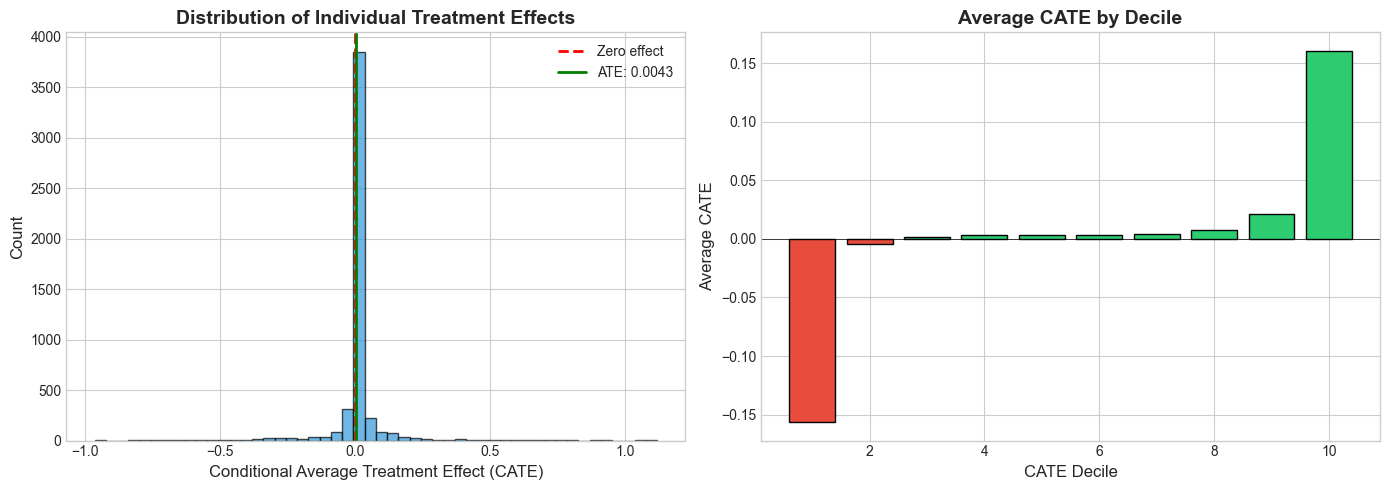

In [17]:
# Visualize CATE distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(cate_estimates, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero effect')
ax1.axvline(hte_results['avg_treatment_effect'], color='green', linestyle='-', linewidth=2, 
            label=f'ATE: {hte_results["avg_treatment_effect"]:.4f}')
ax1.set_xlabel('Conditional Average Treatment Effect (CATE)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Individual Treatment Effects', fontsize=14, fontweight='bold')
ax1.legend()

# Box plot by CATE decile
ax2 = axes[1]
df_hte_copy = df_hte.copy()
df_hte_copy['cate'] = cate_estimates
df_hte_copy['cate_decile'] = pd.qcut(cate_estimates, 10, labels=False, duplicates='drop') + 1

decile_means = df_hte_copy.groupby('cate_decile')['cate'].mean()
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in decile_means]
ax2.bar(decile_means.index, decile_means.values, color=colors, edgecolor='black')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('CATE Decile', fontsize=12)
ax2.set_ylabel('Average CATE', fontsize=12)
ax2.set_title('Average CATE by Decile', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('data/graphs/hte_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Step 5: Sequential Testing (O'Brien-Fleming)

### Why Sequential Testing?

Traditional A/B tests require you to:
1. Calculate required sample size upfront
2. Wait until you collect all data
3. Analyze only once at the end

**Problem:** What if the effect is HUGE (or TERRIBLE)? You can't stop early.

**Sequential testing** allows you to analyze data at multiple "looks" and potentially stop early while controlling Type I error.

### O'Brien-Fleming Boundaries

O'Brien-Fleming is a conservative spending function:
- **Very strict early** (z > 4.3 at 25% of data)
- **Relaxes toward end** (z > 1.96 at 100% of data)

This makes it hard to stop early on noise, but easy to stop when you have strong evidence.

### Alternative: Pocock

Pocock uses **equal boundaries** at all looks:
- Easier to stop early
- But: higher risk of false positives

**Industry preference:** O'Brien-Fleming (more conservative)

---

In [18]:
# Set up sequential testing with 4 looks
n_looks = 4
look_fractions = [0.25, 0.50, 0.75, 1.00]

seq_result = sequential.obrien_fleming_boundaries(
    n_looks=n_looks,
    alpha=0.05,
    two_sided=True
)

print("Sequential Testing: O'Brien-Fleming Boundaries")
print("=" * 50)
print(f"\nPlanned looks: {n_looks}")
print(f"Overall alpha: 0.05 (5% Type I error)")
print(f"\nDecision boundaries:")
print(f"{'Look':<6} {'Data %':<10} {'Boundary (|z|)':<15} {'Interpretation'}")
print("-" * 60)
for i, (frac, boundary) in enumerate(zip(look_fractions, seq_result['boundaries'])):
    if i == 0:
        interp = "Very strict (hard to stop)"
    elif i == len(look_fractions) - 1:
        interp = "Standard threshold"
    else:
        interp = "Moderately strict"
    print(f"{i+1:<6} {frac*100:>5.0f}%{'':<5} {boundary:>8.3f}{'':<7} {interp}")

Sequential Testing: O'Brien-Fleming Boundaries

Planned looks: 4
Overall alpha: 0.05 (5% Type I error)

Decision boundaries:
Look   Data %     Boundary (|z|)  Interpretation
------------------------------------------------------------
1         25%         3.920        Very strict (hard to stop)
2         50%         2.772        Moderately strict
3         75%         2.263        Moderately strict
4        100%         1.960        Standard threshold


In [19]:
# Check if we could have stopped early with current data
current_z = abs(primary_result.get('z_statistic', 0))

print(f"\nCurrent Analysis:")
print(f"  Z-statistic: {current_z:.3f}")
print(f"\nWould we stop early?")

stopped_early = False
stop_look = None

for i, boundary in enumerate(seq_result['boundaries']):
    if current_z > boundary:
        stopped_early = True
        stop_look = i + 1
        break

if stopped_early:
    print(f"  ✓ YES - Could stop at Look {stop_look} ({look_fractions[stop_look-1]*100:.0f}% of data)")
    print(f"  ✓ z = {current_z:.3f} > boundary = {seq_result['boundaries'][stop_look-1]:.3f}")
    print(f"  ✓ Time saved: {(1 - look_fractions[stop_look-1])*100:.0f}% of planned duration")
else:
    print(f"  ○ NO - Current z ({current_z:.3f}) below all boundaries")
    print(f"  ○ Need stronger evidence or more data")


Current Analysis:
  Z-statistic: 3.479

Would we stop early?
  ✓ YES - Could stop at Look 2 (50% of data)
  ✓ z = 3.479 > boundary = 2.772
  ✓ Time saved: 50% of planned duration


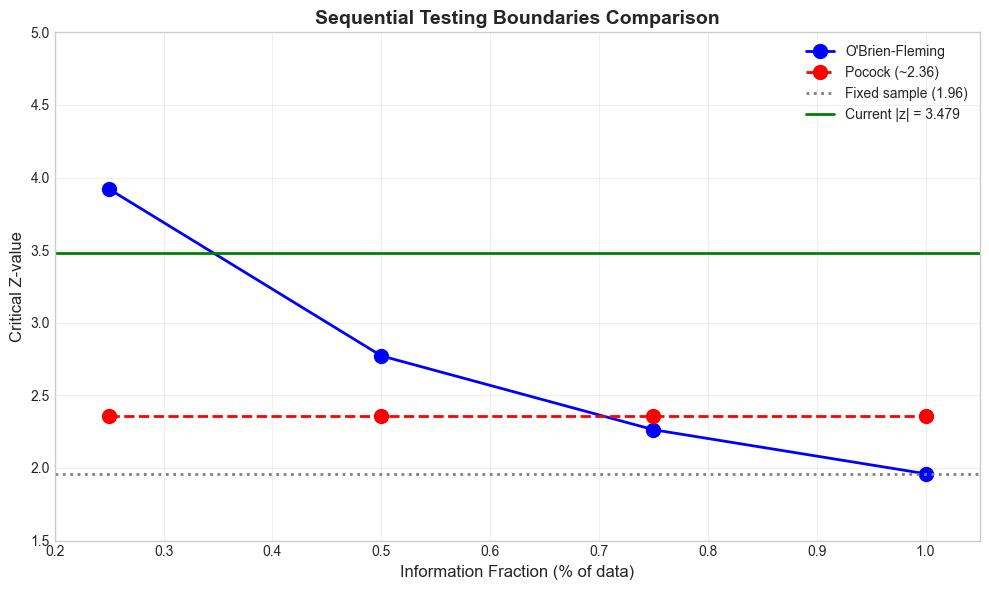

In [20]:
# Visualize boundaries
fig, ax = plt.subplots(figsize=(10, 6))

# O'Brien-Fleming boundaries
ax.plot(look_fractions, seq_result['boundaries'], 'b-o', linewidth=2, markersize=10, label='O\'Brien-Fleming')

# Compare with Pocock (constant boundaries)
pocock_result = sequential.obrien_fleming_boundaries(n_looks=n_looks, alpha=0.05, two_sided=True)
# Pocock has approximately constant boundaries - let's calculate them
from scipy import stats
# Pocock boundary is approximately 2.36 for 4 looks at alpha=0.05
pocock_boundary = 2.36
ax.plot(look_fractions, [pocock_boundary]*4, 'r--o', linewidth=2, markersize=10, label=f'Pocock (~{pocock_boundary:.2f})')

# Standard fixed-sample boundary
ax.axhline(1.96, color='gray', linestyle=':', linewidth=2, label='Fixed sample (1.96)')

# Current z-statistic
ax.axhline(current_z, color='green', linestyle='-', linewidth=2, label=f'Current |z| = {current_z:.3f}')

ax.set_xlabel('Information Fraction (% of data)', fontsize=12)
ax.set_ylabel('Critical Z-value', fontsize=12)
ax.set_title('Sequential Testing Boundaries Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0.2, 1.05)
ax.set_ylim(1.5, 5)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/graphs/sequential_boundaries.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Step 6: Guardrails and Final Decision

---

In [21]:
# Guardrail: Conversion rate should not decrease significantly
control_conversions = control['conversion'].values
treatment_conversions = treatment['conversion'].values

guardrail_result = guardrails.non_inferiority_test(
    control=control_conversions,
    treatment=treatment_conversions,
    delta=-0.02,  # Allow up to 2% relative degradation
    metric_type='relative',
    alpha=0.05
)
guardrail_result['metric_name'] = 'Conversion Rate'

print("Guardrail: Conversion Rate")
print("=" * 50)
print(f"Tolerance: -2.0% (max allowed degradation)")
print(f"\nControl mean:   {guardrail_result['mean_control']:.6f}")
print(f"Treatment mean: {guardrail_result['mean_treatment']:.6f}")
print(f"\nDifference:     {guardrail_result['difference']:.6f}")
print(f"95% CI lower:   {guardrail_result['ci_lower']:.6f}")
print(f"\nResult: {'✓ PASSED' if guardrail_result['passed'] else '✗ FAILED'}")

Guardrail: Conversion Rate
Tolerance: -2.0% (max allowed degradation)

Control mean:   0.000985
Treatment mean: 0.002845

Difference:     0.001861
95% CI lower:   0.000463

Result: ✓ PASSED


In [22]:
# Make final decision
decision_result = guardrails.evaluate_guardrails(
    primary_result=primary_result,
    guardrail_results=[guardrail_result]
)

print("\n" + "=" * 60)
print("FINAL DECISION FRAMEWORK")
print("=" * 60)

print(f"\n🎯 Primary Metric: Visit Rate")
print(f"   Significant: {decision_result['primary_significant']}")
print(f"   Positive:    {decision_result['primary_positive']}")
print(f"   Lift:        {primary_result['relative_lift']:.2%}")

print(f"\n🛡️  Guardrails:")
print(f"   Passed: {decision_result['guardrails_passed']}/{decision_result['guardrails_total']}")
print(f"   - Conversion Rate: {'✓ PASSED' if guardrail_result['passed'] else '✗ FAILED'}")

print(f"\n📊 Heterogeneous Effects:")
if hte_results['cate_std'] > 0.01:
    print(f"   ⚠️  High heterogeneity - consider targeted rollout")
    print(f"   {hte_results['negative_effect_pct']:.1f}% of users have negative effects")
else:
    print(f"   ✓ Low heterogeneity - uniform effect across users")

decision = decision_result['decision'].upper()
print(f"\n" + "=" * 60)
print(f">>> FINAL DECISION: {decision} <<<")
print("=" * 60)


FINAL DECISION FRAMEWORK

🎯 Primary Metric: Visit Rate
   Significant: True
   Positive:    True
   Lift:        54.78%

🛡️  Guardrails:
   Passed: 1/1
   - Conversion Rate: ✓ PASSED

📊 Heterogeneous Effects:
   ⚠️  High heterogeneity - consider targeted rollout
   22.9% of users have negative effects

>>> FINAL DECISION: SHIP <<<


---

## Summary and Key Learnings

### Advanced Techniques Covered

1. **Large-Scale Data Handling**
   - Sampling strategies for efficiency
   - Trade-offs between speed and precision
   - At scale, tiny effects can be statistically but not practically significant

2. **SRM with Designed Imbalance**
   - Not all imbalance is bad - some is by design
   - Check against DESIGNED allocation, not 50/50
   - Two-stage gating: statistical + practical significance

3. **CUPAC (ML Variance Reduction)**
   - Uses ML instead of linear regression
   - Captures non-linear relationships and interactions
   - Can achieve 30-50% variance reduction (like 1.5-2x more users)
   - Industry standard at Netflix, DoorDash, Microsoft

4. **Heterogeneous Treatment Effects (X-Learner)**
   - Goes beyond average effects to individual-level predictions
   - Enables personalization and targeted rollouts
   - Use cases: Uber promotions, Netflix recommendations, Amazon features

5. **Sequential Testing (O'Brien-Fleming)**
   - Allows early stopping while controlling Type I error
   - O'Brien-Fleming: Conservative, preferred in industry
   - Plan looks upfront, don't peek randomly

### When to Use Each Technique

| Technique | When to Use | When NOT to Use |
|-----------|-------------|----------------|
| CUPAC | Rich features, large samples | Few features, small samples |
| X-Learner | Personalization needed, >10K samples | Simple ship/no-ship decision |
| Sequential | Long experiments, safety concerns | Short experiments |

---

## Exercises

### Exercise 1: Compare CUPAC Models

Try running CUPAC with different model types ('gbm', 'rf', 'ridge'). Which gives the best variance reduction?

In [23]:
# YOUR CODE HERE


### Exercise 2: Analyze Top CATE Segment

Create a profile of users in the top 10% CATE. What features characterize them?

In [24]:
# YOUR CODE HERE


### Exercise 3: Vary Sample Size

Run the analysis with sample_frac=0.01 (1%) instead of 0.001 (0.1%). How do the results change?

In [25]:
# YOUR CODE HERE
